Reza Soleimani 260984835

**End-to-end Machine Learning project**

*Data source: https://www.kaggle.com/phileinsophos/predict-loan-amount-data?select=train.csv*


# 1. Framing the Problem

The selected dataset consists of ~30,000 loan application data and the issued loan amount. For each loan application, 24 variables are measured. These variables depict the information of each loan applicant. The objective is to predict sanctioned loan amount values for each application using regression models. From loan issuer perspective, this analysis can help to have an initial understanding of the expected loan that each applicant by specific information can get.
MSE of the regressrion will be used to assess the outcome of analysis. To avoid overfitting, cross validation techniques will be implemented.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

# Import the Data

In [2]:
import pandas as pd
loan_df = pd.read_csv ("Sanctioned Loan Amount Prediction Dataset.csv")
loan_df.dropna(subset=["Loan Sanction Amount (USD)"], inplace=True)  # drop rows with null values in label column
loan_df.reset_index(drop=True, inplace=True)   # reset the dataframe index 

# 2. Data exploration

In [3]:
loan_df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29660 entries, 0 to 29659
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  29660 non-null  object 
 1   Name                         29660 non-null  object 
 2   Gender                       29608 non-null  object 
 3   Age                          29660 non-null  int64  
 4   Income (USD)                 25167 non-null  float64
 5   Income Stability             28002 non-null  object 
 6   Profession                   29660 non-null  object 
 7   Type of Employment           22472 non-null  object 
 8   Location                     29660 non-null  object 
 9   Loan Amount Request (USD)    29660 non-null  float64
 10  Current Loan Expenses (USD)  29493 non-null  float64
 11  Expense Type 1               29660 non-null  object 
 12  Expense Type 2               29660 non-null  object 
 13  Dependents      

In [5]:
loan_df["Customer ID"].value_counts()

C-11309    1
C-13202    1
C-43791    1
C-16019    1
C-12293    1
          ..
C-43394    1
C-44653    1
C-22242    1
C-7704     1
C-13411    1
Name: Customer ID, Length: 29660, dtype: int64

In [6]:
loan_df["Name"].value_counts()

Larae Mazzoni        1
Donald Lebron        1
Darius Lemons        1
Lizette Near         1
Idalia Swan          1
                    ..
Reyna Shaughnessy    1
William Verne        1
Kraig Mcmillan       1
Lawerence Sabbagh    1
Carmelo Rakestraw    1
Name: Name, Length: 29660, dtype: int64

In [7]:
loan_df["Gender"].value_counts()

M    14890
F    14718
Name: Gender, dtype: int64

In [8]:
loan_df["Income Stability"].value_counts()

Low     25458
High     2544
Name: Income Stability, dtype: int64

In [9]:
loan_df["Profession"].value_counts()

Working                 16739
Commercial associate     7863
Pensioner                2718
State servant            2334
Unemployed                  2
Businessman                 2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64

In [10]:
loan_df["Type of Employment"].value_counts()

Laborers                 5516
Sales staff              3698
Core staff               3189
Managers                 2464
Drivers                  1588
Accountants              1363
High skill tech staff    1297
Medicine staff            854
Security staff            574
Cooking staff             561
Cleaning staff            338
Private service staff     337
Secretaries               158
Low-skill Laborers        154
Waiters/barmen staff      148
Realty agents              85
IT staff                   77
HR staff                   71
Name: Type of Employment, dtype: int64

In [11]:
loan_df["Location"].value_counts()

Semi-Urban    21317
Rural          5280
Urban          3063
Name: Location, dtype: int64

In [12]:
loan_df["Expense Type 1"].value_counts()

N    18984
Y    10676
Name: Expense Type 1, dtype: int64

In [13]:
loan_df["Expense Type 2"].value_counts()

Y    19949
N     9711
Name: Expense Type 2, dtype: int64

In [14]:
loan_df["Has Active Credit Card"].value_counts()

Active         9668
Inactive       9360
Unpossessed    9086
Name: Has Active Credit Card, dtype: int64

In [15]:
loan_df["Property ID"].value_counts()

839    51
870    45
614    44
382    43
944    43
       ..
760    17
346    17
402    17
299    15
629    15
Name: Property ID, Length: 999, dtype: int64

In [16]:
loan_df["Property Type"].value_counts()

1    7777
2    7560
3    7225
4    7098
Name: Property Type, dtype: int64

In [17]:
loan_df["Property Location"].value_counts()

Semi-Urban    10255
Rural          9929
Urban          9129
Name: Property Location, dtype: int64

In [18]:
loan_df["Co-Applicant"].value_counts()

 1      25202
 0       4293
-999      165
Name: Co-Applicant, dtype: int64

In [19]:
loan_df.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,29660.000000,2.516700e+04,29660.000000,29493.000000,27214.000000,27990.000000,29660.000000,29660.000000,2.490000e+04,29660.000000,29660.000000,2.966000e+04,29660.000000
mean,40.099225,2.630991e+03,88792.057274,400.893752,2.253399,739.853475,0.194066,501.881827,2.631317e+03,2.460013,-4.707788,1.317335e+05,47649.342208
std,16.050024,1.131902e+04,59480.995253,242.265401,0.951987,72.152128,0.395487,288.160738,1.137831e+04,1.118695,74.369350,9.342129e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650250e+03,41200.112500,247.780000,2.000000,681.732500,0.000000,251.000000,1.649810e+03,1.000000,1.000000,6.065874e+04,0.000000
50%,40.000000,2.223300e+03,75114.085000,375.090000,2.000000,739.815000,0.000000,504.000000,2.223965e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090330e+03,119890.857500,521.050000,3.000000,799.040000,0.000000,751.000000,3.090832e+03,3.000000,1.000000,1.788019e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


Saving figure attribute_histogram_plots


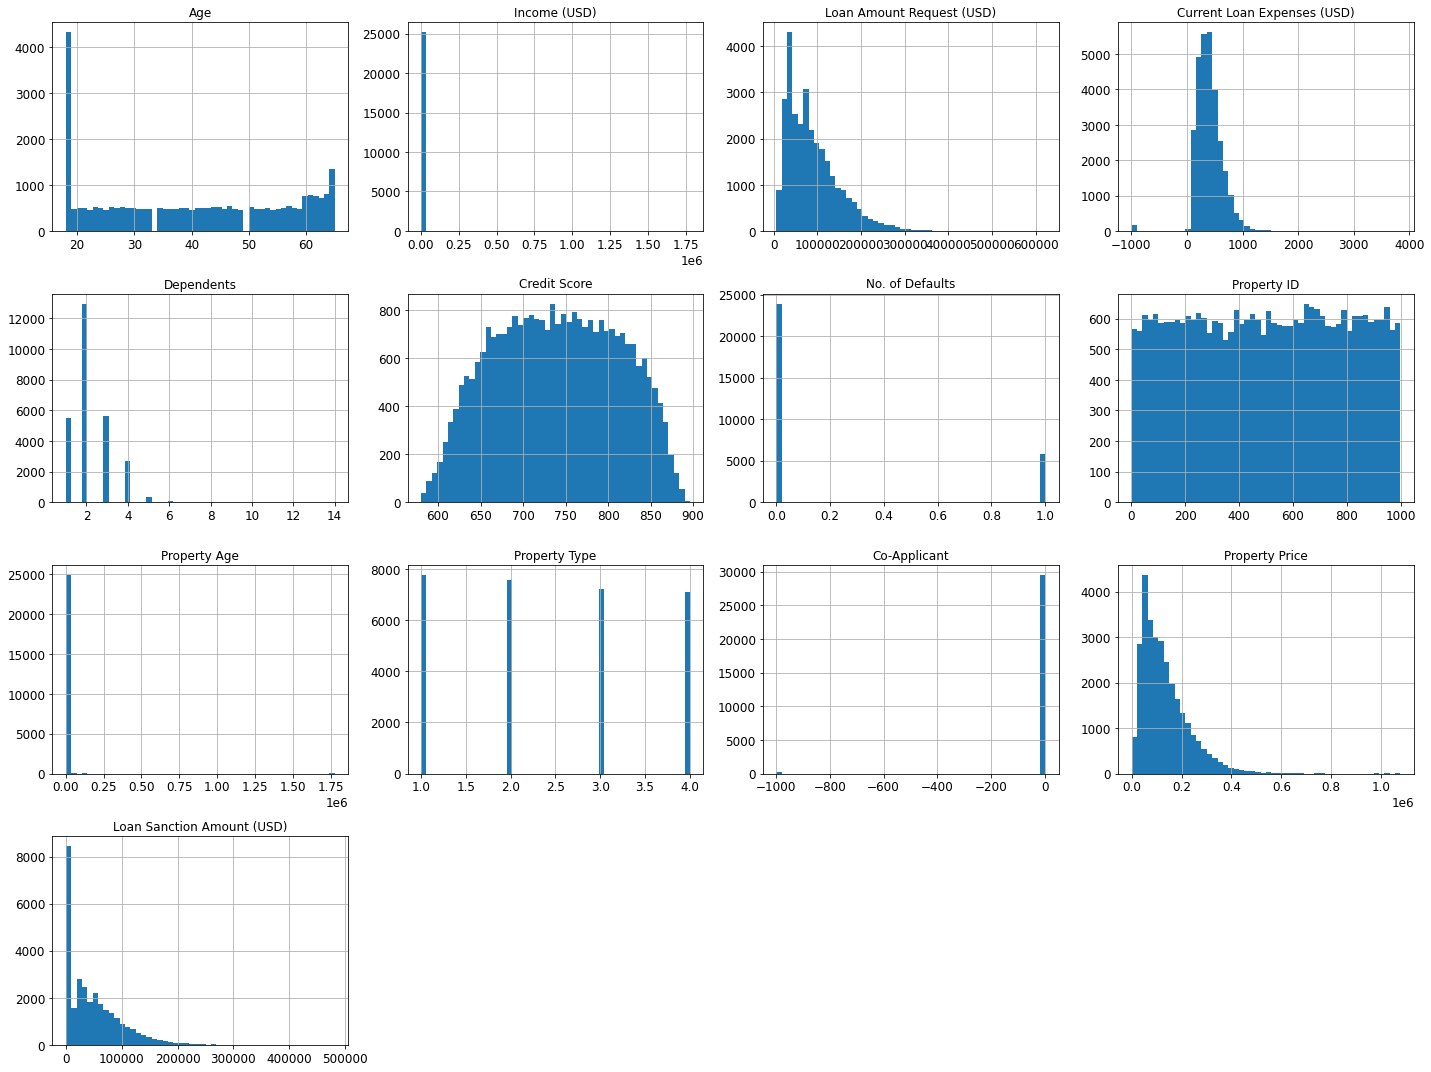

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
loan_df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [21]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [22]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [23]:
train_set, test_set = split_train_test(loan_df, 0.2)
len(train_set)

23728

In [24]:
len(test_set)

5932

In [25]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [26]:
loan_with_id = loan_df.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(loan_with_id, 0.2, "index")

In [27]:
train_set, test_set = split_train_test_by_id(loan_with_id, 0.2, "index")

In [28]:
test_set.head()

,index,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
2,2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
5,5,C-17688,Polly Crumpler,F,60,1234.92,Low,State servant,Secretaries,Rural,...,684.12,1,Inactive,491,1234.92,2,Rural,1,43146.82,22382.57
12,12,C-30073,Brinda Vaz,F,48,777.25,Low,Working,NaN,Semi-Urban,...,764.11,0,Active,678,777.25,1,Semi-Urban,1,146073.26,67256.42
16,16,C-45549,Elidia Mccluney,F,61,2077.42,Low,Working,Realty agents,Semi-Urban,...,779.55,0,Inactive,395,2077.42,4,Rural,1,102502.20,0.00
23,23,C-35716,Blossom Lentine,F,24,2538.85,Low,Working,Laborers,Rural,...,721.27,1,Inactive,640,2538.85,1,Rural,1,170642.55,84367.95


In [29]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(loan_df, test_size=0.2, random_state=42)

In [30]:
test_set.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
25637,C-10160,Arlen Wanamaker,M,35,1848.98,Low,Working,Laborers,Semi-Urban,84001.94,...,NaN,0,Inactive,887,1848.98,1,Rural,1,97181.99,54601.26
23581,C-14801,Deanna Beauchesne,F,44,3168.31,Low,State servant,NaN,Semi-Urban,77944.47,...,730.57,0,Active,948,3168.31,3,Rural,1,121489.68,50663.91
26860,C-6046,Eliz Cheng,M,53,1419.42,Low,Working,Private service staff,Semi-Urban,14015.89,...,652.11,0,Active,576,1419.42,3,Rural,1,23475.22,9110.33
8643,C-46590,Hal Kuo,F,53,2492.76,Low,State servant,Drivers,Semi-Urban,122439.74,...,747.09,0,Active,792,2492.76,4,Rural,1,176859.09,0.00
28968,C-28785,Lucio Borel,F,48,2033.89,Low,Working,Laborers,Semi-Urban,55111.86,...,653.19,0,Inactive,768,2033.89,2,Semi-Urban,1,74233.81,38578.30


<AxesSubplot:>

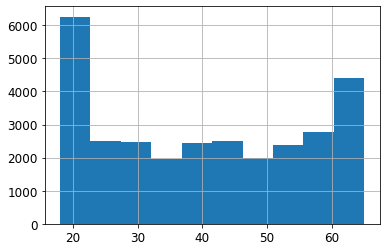

In [31]:
loan_df["Age"].hist()

In [32]:
loan_df["age_cat"] = pd.cut(loan_df["Age"],
                               bins=[0, 20, 30, 40, 50, 60, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [33]:
loan_df["age_cat"].value_counts()

1    5298
5    5185
4    4981
2    4954
3    4835
6    4407
Name: age_cat, dtype: int64

<AxesSubplot:>

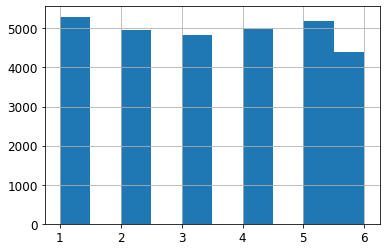

In [34]:
loan_df["age_cat"].hist()

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(loan_df, loan_df["age_cat"]):
    strat_train_set = loan_df.loc[train_index]
    strat_test_set = loan_df.loc[test_index]

In [36]:
strat_test_set["age_cat"].value_counts() / len(strat_test_set)

1    0.178692
5    0.174815
4    0.167903
2    0.167060
3    0.163014
6    0.148517
Name: age_cat, dtype: float64

In [37]:
loan_df["age_cat"].value_counts() / len(loan_df)

1    0.178624
5    0.174815
4    0.167937
2    0.167026
3    0.163014
6    0.148584
Name: age_cat, dtype: float64

In [38]:
def age_cat_proportions(data):
    return data["age_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(loan_df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": age_cat_proportions(loan_df),
    "Stratified": age_cat_proportions(strat_test_set),
    "Random": age_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [39]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.178624,0.178692,0.181558,1.642129,3.775009e-02
2,0.167026,0.167060,0.168409,0.827614,2.018571e-02
3,0.163014,0.163014,0.165037,1.240951,-1.421085e-14
4,0.167937,0.167903,0.166049,-1.124272,-2.007629e-02
5,0.174815,0.174815,0.173803,-0.578592,0.000000e+00
6,0.148584,0.148517,0.145145,-2.314500,-4.538235e-02


In [40]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [41]:
loan_df = strat_train_set.copy()

## Visualizing Geographical Data

Saving figure bad_visualization_plot


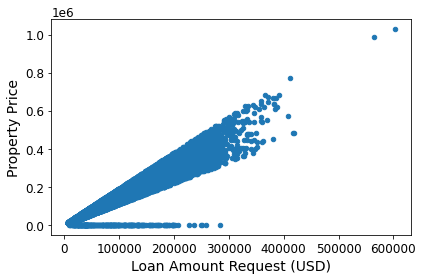

In [42]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


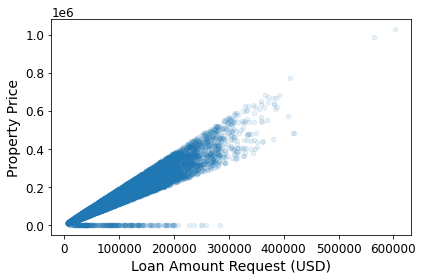

In [43]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed)

Saving figure loan_sanction_amount_scatterplot


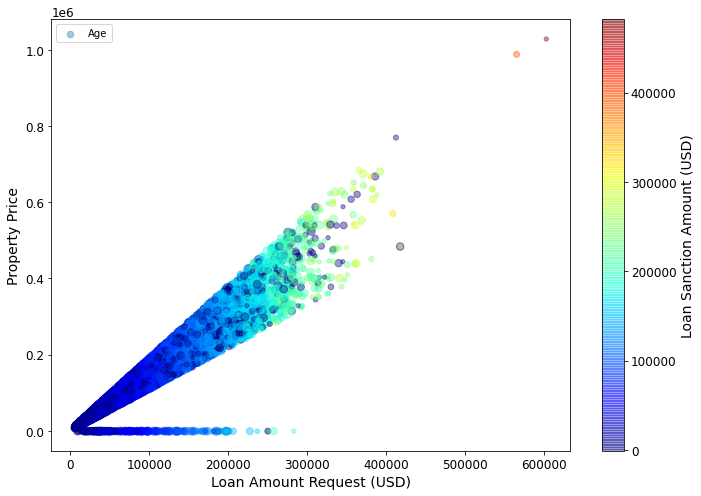

In [44]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price", alpha=0.4,
             s=loan_df["Age"], label="Age", figsize=(10,7),
             c="Loan Sanction Amount (USD)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("loan_sanction_amount_scatterplot")

## Looking for Correlations

In [45]:
corr_matrix = loan_df.corr()

In [46]:
corr_matrix["Loan Sanction Amount (USD)"].sort_values(ascending=False)

Loan Sanction Amount (USD)     1.000000
Loan Amount Request (USD)      0.726708
Property Price                 0.688896
Current Loan Expenses (USD)    0.486093
Credit Score                   0.368329
Income (USD)                   0.035110
Property Age                   0.034789
Age                            0.007685
Dependents                     0.006162
Property Type                  0.002239
No. of Defaults               -0.004063
Co-Applicant                  -0.006897
Property ID                   -0.011950
Name: Loan Sanction Amount (USD), dtype: float64

Saving figure scatter_matrix_plot


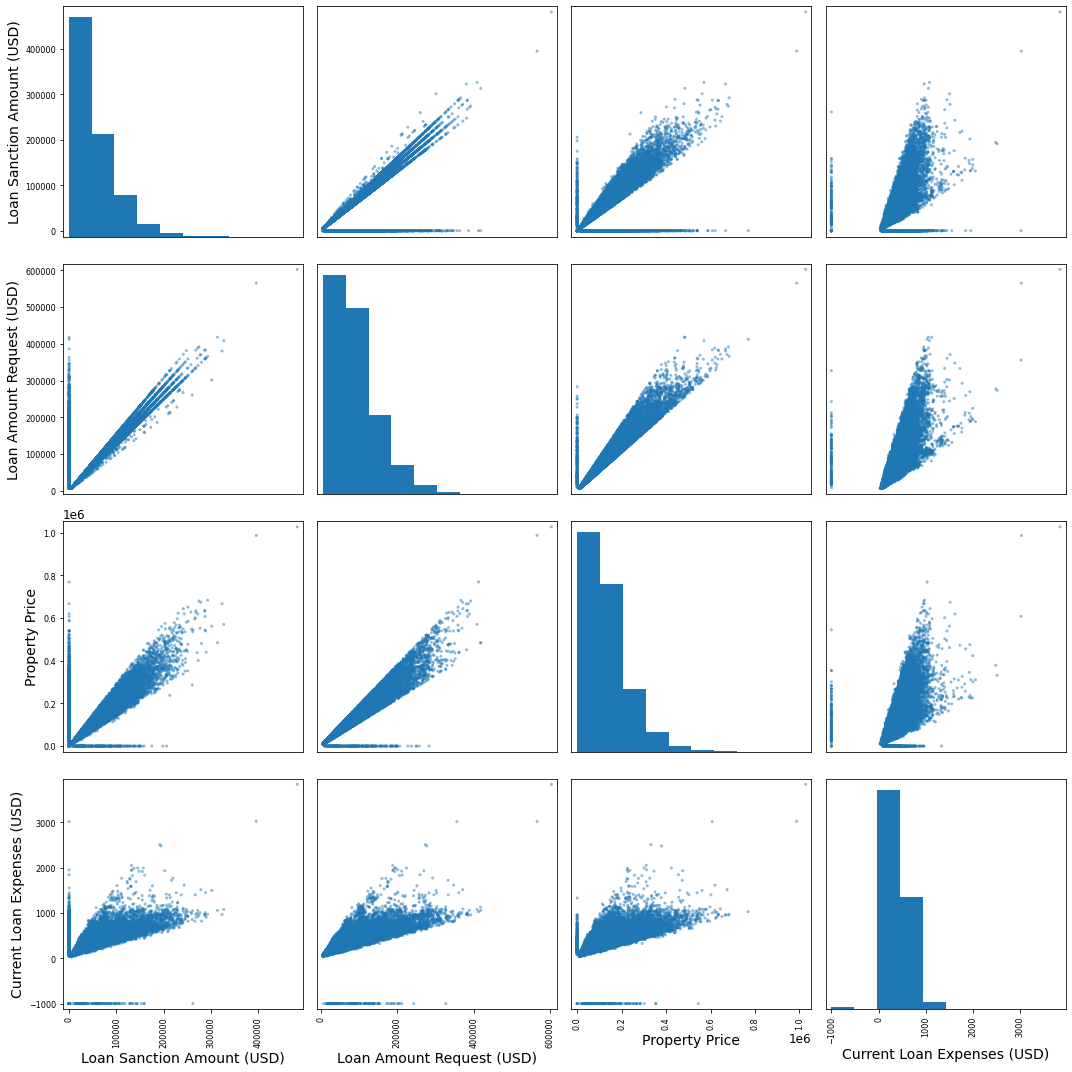

In [47]:
from pandas.plotting import scatter_matrix

attributes = ["Loan Sanction Amount (USD)","Loan Amount Request (USD)", "Property Price",
              "Current Loan Expenses (USD)"]
scatter_matrix(loan_df[attributes], figsize=(15, 15))
save_fig("scatter_matrix_plot")

Saving figure loan_amount_vs_request_value_scatterplot


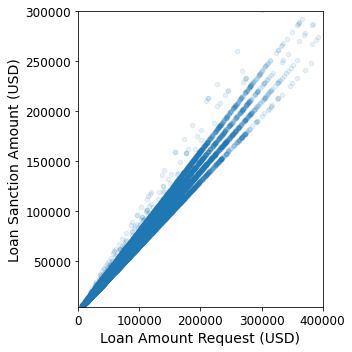

In [48]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Loan Sanction Amount (USD)",
             alpha=0.1, figsize=(5, 5))
plt.axis([0, 400000, 4000, 300000])
save_fig("loan_amount_vs_request_value_scatterplot")

## Experimenting with Attribute Combinations

In [49]:
loan_df["Loan_Request_to_Income"] = loan_df["Loan Amount Request (USD)"]/loan_df["Income (USD)"]
loan_df["Loan_Request_to_Property_Price"] = loan_df["Loan Amount Request (USD)"]/loan_df["Property Price"]

In [50]:
corr_matrix = loan_df.corr()
corr_matrix["Loan Sanction Amount (USD)"].sort_values(ascending=False)

Loan Sanction Amount (USD)        1.000000
Loan Amount Request (USD)         0.726708
Property Price                    0.688896
Current Loan Expenses (USD)       0.486093
Loan_Request_to_Income            0.461432
Credit Score                      0.368329
Income (USD)                      0.035110
Property Age                      0.034789
Age                               0.007685
Dependents                        0.006162
Property Type                     0.002239
No. of Defaults                  -0.004063
Co-Applicant                     -0.006897
Property ID                      -0.011950
Loan_Request_to_Property_Price   -0.056198
Name: Loan Sanction Amount (USD), dtype: float64

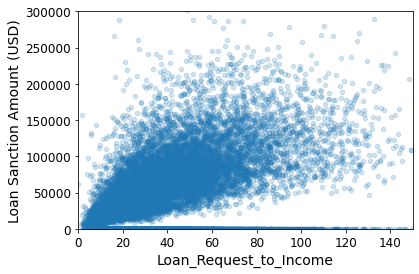

In [51]:
loan_df.plot(kind="scatter", x="Loan_Request_to_Income", y="Loan Sanction Amount (USD)",
             alpha=0.2)
plt.axis([0, 150, 0, 300000])
plt.show()

In [52]:
loan_df.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),Loan_Request_to_Income,Loan_Request_to_Property_Price
count,23728.000000,2.014900e+04,23728.000000,23594.000000,21792.000000,22396.000000,23728.000000,23728.00000,1.992600e+04,23728.000000,23728.000000,2.372800e+04,23728.000000,20149.000000,23728.000000
mean,40.092127,2.643728e+03,88813.506711,401.226948,2.251973,739.583787,0.195550,500.96894,2.644264e+03,2.455664,-4.791976,1.318421e+05,47541.018363,38.503001,-0.316143
std,16.047550,1.262162e+04,59450.394454,243.305100,0.951184,72.115566,0.396632,288.02619,1.269087e+04,1.116386,74.927770,9.355608e+04,48218.030219,25.682506,11.030983
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.00000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000,0.049360,-283.251461
25%,25.000000,1.650450e+03,41275.240000,248.702500,2.000000,681.825000,0.000000,250.00000,1.650165e+03,1.000000,1.000000,6.065837e+04,0.000000,20.225324,0.585267
50%,40.000000,2.216680e+03,75106.755000,374.440000,2.000000,739.500000,0.000000,503.00000,2.218770e+03,2.000000,1.000000,1.100038e+05,35209.395000,31.816588,0.663693
75%,55.000000,3.085420e+03,119845.255000,520.485000,3.000000,798.812500,0.000000,749.00000,3.087290e+03,3.000000,1.000000,1.787341e+05,74022.315000,50.357404,0.768149
max,65.000000,1.777460e+06,602384.150000,3840.880000,14.000000,896.260000,1.000000,999.00000,1.777460e+06,4.000000,1.000000,1.028083e+06,481907.320000,323.376763,0.909014


# 3. Data prepraration

In [133]:
loan_df = strat_train_set.drop("Loan Sanction Amount (USD)", axis=1) # drop labels for training set
loan_df_labels = strat_train_set["Loan Sanction Amount (USD)"].copy()

## Data Cleaning

In the book 3 options are listed:

```python
loan_df.dropna(subset=["Income (USD)"])    # option 1
loan_df.drop("Income (USD)", axis=1)       # option 2
median = loan_dg["Income (USD)"].median()  # option 3
loan_df["Income (USD)"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [144]:
sample_incomplete_rows = loan_df[loan_df.isnull().any(axis=1)]
sample_incomplete_rows

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
23657,C-17404,Leslie Kinsey,M,64,NaN,High,Pensioner,NaN,Urban,105998.97,...,2.0,847.81,1,Inactive,774,NaN,3,Urban,1,133045.25
19468,C-16420,Caroyln Lawry,M,53,1583.23,Low,Working,NaN,Semi-Urban,116486.82,...,2.0,859.43,0,Inactive,128,1583.23,1,Rural,1,194235.72
21609,C-12519,Darlena Haddox,F,20,3490.06,Low,Commercial associate,NaN,Semi-Urban,60793.29,...,2.0,619.19,0,NaN,326,3490.06,3,Urban,0,67027.42
5123,C-23156,Merlyn Chadwell,F,56,NaN,Low,Working,Core staff,Semi-Urban,124171.75,...,3.0,709.70,0,Active,129,NaN,4,Semi-Urban,1,184446.89
9020,C-33243,Marlena Grajeda,F,52,2440.02,Low,Commercial associate,NaN,Semi-Urban,104883.68,...,2.0,701.74,0,Unpossessed,931,2440.02,2,Urban,1,122242.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,C-17141,Birgit Eddleman,F,18,NaN,Low,Working,Sales staff,Semi-Urban,78150.96,...,1.0,637.14,1,Unpossessed,764,NaN,1,Urban,1,125033.35
2320,C-32662,Sallie Vancleve,F,52,1332.02,Low,Working,NaN,Rural,18766.37,...,3.0,736.93,0,NaN,146,1332.02,2,Semi-Urban,1,24411.63
20354,C-36495,Lenita Oakman,M,40,2417.46,Low,Commercial associate,Sales staff,Urban,28142.05,...,3.0,631.33,0,NaN,327,2417.46,1,Rural,1,48232.77
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,1.0,NaN,1,Active,273,1510.64,4,Rural,1,37296.71


In [139]:
sample_incomplete_rows.isnull().sum()

Customer ID                       0
Name                              0
Gender                           42
Age                               0
Income (USD)                   3579
Income Stability               1322
Profession                        0
Type of Employment             5734
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     134
Expense Type 1                    0
Expense Type 2                    0
Dependents                     1936
Credit Score                   1332
No. of Defaults                   0
Has Active Credit Card         1266
Property ID                       0
Property Age                   3802
Property Type                     0
Property Location               271
Co-Applicant                      0
Property Price                    0
dtype: int64

In [140]:
sample_incomplete_rows.dropna(subset=["Income (USD)"])    # option 1

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
19468,C-16420,Caroyln Lawry,M,53,1583.23,Low,Working,NaN,Semi-Urban,116486.82,...,2.0,859.43,0,Inactive,128,1583.23,1,Rural,1,194235.72
21609,C-12519,Darlena Haddox,F,20,3490.06,Low,Commercial associate,NaN,Semi-Urban,60793.29,...,2.0,619.19,0,NaN,326,3490.06,3,Urban,0,67027.42
9020,C-33243,Marlena Grajeda,F,52,2440.02,Low,Commercial associate,NaN,Semi-Urban,104883.68,...,2.0,701.74,0,Unpossessed,931,2440.02,2,Urban,1,122242.07
25777,C-30530,Augustus Burgett,F,65,1064.44,High,Pensioner,NaN,Semi-Urban,27752.82,...,1.0,727.37,0,Unpossessed,622,1064.44,3,Semi-Urban,1,36331.63
182,C-6086,Walter Hipps,F,65,911.24,High,Pensioner,NaN,Rural,31484.72,...,2.0,851.02,0,Active,378,911.24,2,Rural,1,57401.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,C-6664,Kenny Ing,F,53,6806.62,NaN,Working,Managers,Rural,65958.74,...,NaN,871.08,0,Inactive,724,6806.62,3,Urban,1,120848.11
2320,C-32662,Sallie Vancleve,F,52,1332.02,Low,Working,NaN,Rural,18766.37,...,3.0,736.93,0,NaN,146,1332.02,2,Semi-Urban,1,24411.63
20354,C-36495,Lenita Oakman,M,40,2417.46,Low,Commercial associate,Sales staff,Urban,28142.05,...,3.0,631.33,0,NaN,327,2417.46,1,Rural,1,48232.77
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,1.0,NaN,1,Active,273,1510.64,4,Rural,1,37296.71


In [143]:
sample_incomplete_rows.drop("Income (USD)", axis=1)       # option 2

,Customer ID,Name,Gender,Age,Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),...,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
23657,C-17404,Leslie Kinsey,M,64,High,Pensioner,NaN,Urban,105998.97,1117.84,...,2.0,847.81,1,Inactive,774,NaN,3,Urban,1,133045.25
19468,C-16420,Caroyln Lawry,M,53,Low,Working,NaN,Semi-Urban,116486.82,312.77,...,2.0,859.43,0,Inactive,128,1583.23,1,Rural,1,194235.72
21609,C-12519,Darlena Haddox,F,20,Low,Commercial associate,NaN,Semi-Urban,60793.29,421.48,...,2.0,619.19,0,NaN,326,3490.06,3,Urban,0,67027.42
5123,C-23156,Merlyn Chadwell,F,56,Low,Working,Core staff,Semi-Urban,124171.75,650.84,...,3.0,709.70,0,Active,129,NaN,4,Semi-Urban,1,184446.89
9020,C-33243,Marlena Grajeda,F,52,Low,Commercial associate,NaN,Semi-Urban,104883.68,333.17,...,2.0,701.74,0,Unpossessed,931,2440.02,2,Urban,1,122242.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,C-17141,Birgit Eddleman,F,18,Low,Working,Sales staff,Semi-Urban,78150.96,538.11,...,1.0,637.14,1,Unpossessed,764,NaN,1,Urban,1,125033.35
2320,C-32662,Sallie Vancleve,F,52,Low,Working,NaN,Rural,18766.37,99.97,...,3.0,736.93,0,NaN,146,1332.02,2,Semi-Urban,1,24411.63
20354,C-36495,Lenita Oakman,M,40,Low,Commercial associate,Sales staff,Urban,28142.05,135.54,...,3.0,631.33,0,NaN,327,2417.46,1,Rural,1,48232.77
20410,C-8689,Angelyn Linen,F,18,Low,Working,Laborers,Rural,26067.36,134.80,...,1.0,NaN,1,Active,273,1510.64,4,Rural,1,37296.71


In [145]:
median = loan_df["Income (USD)"].median()
sample_incomplete_rows["Income (USD)"].fillna(median, inplace=True) # option 3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [146]:
sample_incomplete_rows

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
23657,C-17404,Leslie Kinsey,M,64,2216.68,High,Pensioner,NaN,Urban,105998.97,...,2.0,847.81,1,Inactive,774,NaN,3,Urban,1,133045.25
19468,C-16420,Caroyln Lawry,M,53,1583.23,Low,Working,NaN,Semi-Urban,116486.82,...,2.0,859.43,0,Inactive,128,1583.23,1,Rural,1,194235.72
21609,C-12519,Darlena Haddox,F,20,3490.06,Low,Commercial associate,NaN,Semi-Urban,60793.29,...,2.0,619.19,0,NaN,326,3490.06,3,Urban,0,67027.42
5123,C-23156,Merlyn Chadwell,F,56,2216.68,Low,Working,Core staff,Semi-Urban,124171.75,...,3.0,709.70,0,Active,129,NaN,4,Semi-Urban,1,184446.89
9020,C-33243,Marlena Grajeda,F,52,2440.02,Low,Commercial associate,NaN,Semi-Urban,104883.68,...,2.0,701.74,0,Unpossessed,931,2440.02,2,Urban,1,122242.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,C-17141,Birgit Eddleman,F,18,2216.68,Low,Working,Sales staff,Semi-Urban,78150.96,...,1.0,637.14,1,Unpossessed,764,NaN,1,Urban,1,125033.35
2320,C-32662,Sallie Vancleve,F,52,1332.02,Low,Working,NaN,Rural,18766.37,...,3.0,736.93,0,NaN,146,1332.02,2,Semi-Urban,1,24411.63
20354,C-36495,Lenita Oakman,M,40,2417.46,Low,Commercial associate,Sales staff,Urban,28142.05,...,3.0,631.33,0,NaN,327,2417.46,1,Rural,1,48232.77
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,1.0,NaN,1,Active,273,1510.64,4,Rural,1,37296.71


In [60]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [61]:
# loan_df_num = loan_df.drop("Gender", axis=1)
loan_df_num = loan_df.select_dtypes(include=[np.number])

In [62]:
imputer.fit(loan_df_num)

SimpleImputer(strategy='median')

In [63]:
imputer.statistics_

array([4.00000000e+01, 2.21668000e+03, 7.51067550e+04, 3.74440000e+02,
       2.00000000e+00, 7.39500000e+02, 0.00000000e+00, 5.03000000e+02,
       2.21877000e+03, 2.00000000e+00, 1.00000000e+00, 1.10003845e+05])

Check that this is the same as manually computing the median of each attribute:

In [64]:
loan_df_num.median().values

array([4.00000000e+01, 2.21668000e+03, 7.51067550e+04, 3.74440000e+02,
       2.00000000e+00, 7.39500000e+02, 0.00000000e+00, 5.03000000e+02,
       2.21877000e+03, 2.00000000e+00, 1.00000000e+00, 1.10003845e+05])

Transform the training set:

In [65]:
X = imputer.transform(loan_df_num)

In [66]:
loan_df_tr = pd.DataFrame(X, columns=loan_df_num.columns,
                          index=loan_df.index)

In [67]:
loan_df_tr.loc[sample_incomplete_rows.index.values]

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price
23657,64.0,2216.68,105998.97,1117.84,2.0,847.81,1.0,774.0,2218.77,3.0,1.0,133045.25
19468,53.0,1583.23,116486.82,312.77,2.0,859.43,0.0,128.0,1583.23,1.0,1.0,194235.72
21609,20.0,3490.06,60793.29,421.48,2.0,619.19,0.0,326.0,3490.06,3.0,0.0,67027.42
5123,56.0,2216.68,124171.75,650.84,3.0,709.70,0.0,129.0,2218.77,4.0,1.0,184446.89
9020,52.0,2440.02,104883.68,333.17,2.0,701.74,0.0,931.0,2440.02,2.0,1.0,122242.07
...,...,...,...,...,...,...,...,...,...,...,...,...
16590,18.0,2216.68,78150.96,538.11,1.0,637.14,1.0,764.0,2218.77,1.0,1.0,125033.35
2320,52.0,1332.02,18766.37,99.97,3.0,736.93,0.0,146.0,1332.02,2.0,1.0,24411.63
20354,40.0,2417.46,28142.05,135.54,3.0,631.33,0.0,327.0,2417.46,1.0,1.0,48232.77
20410,18.0,1510.64,26067.36,134.80,1.0,739.50,1.0,273.0,1510.64,4.0,1.0,37296.71


In [68]:
imputer.strategy

'median'

In [69]:
loan_df_tr = pd.DataFrame(X, columns=loan_df_num.columns,
                          index=loan_df_num.index)

In [70]:
loan_df_tr

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price
6406,45.0,2067.47,82934.04,421.69,2.0,764.80,0.0,497.0,2067.47,1.0,1.0,136962.32
13011,53.0,3664.28,182017.80,701.13,4.0,742.68,0.0,791.0,3664.28,1.0,1.0,312345.44
24769,28.0,4194.06,64737.67,535.61,2.0,814.64,1.0,46.0,4194.06,2.0,1.0,78786.84
16131,35.0,5506.36,288712.23,747.66,2.0,765.05,1.0,100.0,5506.36,2.0,0.0,457905.34
21923,29.0,1611.71,120105.22,440.86,3.0,795.81,0.0,478.0,1611.71,1.0,1.0,208676.37
...,...,...,...,...,...,...,...,...,...,...,...,...
20410,18.0,1510.64,26067.36,134.80,1.0,739.50,1.0,273.0,1510.64,4.0,1.0,37296.71
10651,18.0,2762.50,32616.54,164.09,2.0,738.27,0.0,456.0,2762.50,3.0,1.0,60434.80
23064,63.0,3435.20,107706.39,508.47,3.0,765.96,0.0,132.0,3435.20,1.0,1.0,187838.76
2493,26.0,1555.88,77354.46,379.35,3.0,626.36,0.0,619.0,1555.88,4.0,1.0,120467.59


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input features, excluding `Customer ID` and `Name` variables:

In [71]:
loan_df_cat = loan_df[["Gender","Income Stability","Profession","Type of Employment","Location","Expense Type 1",
                       "Expense Type 2", "Has Active Credit Card", "Property Location"]]
loan_df_cat.drop("Type of Employment", axis=1, inplace=True) 
loan_df_cat=loan_df_cat.dropna()  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [72]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
loan_df_cat_encoded = ordinal_encoder.fit_transform(loan_df_cat)
loan_df_cat_encoded[:10]

array([[1., 1., 4., 1., 0., 1., 1., 1.],
       [1., 1., 4., 2., 1., 0., 2., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 4., 1., 0., 0., 0., 0.],
       [1., 1., 4., 1., 0., 0., 2., 2.],
       [1., 0., 1., 2., 1., 1., 1., 2.],
       [1., 1., 4., 1., 1., 1., 1., 0.],
       [0., 1., 4., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 2., 2.]])

In [73]:
ordinal_encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['High', 'Low'], dtype=object),
 array(['Commercial associate', 'Pensioner', 'State servant', 'Unemployed',
        'Working'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Active', 'Inactive', 'Unpossessed'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object)]

In [74]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
loan_df_cat_1hot = cat_encoder.fit_transform(loan_df_cat)
loan_df_cat_1hot

<20933x22 sparse matrix of type '<class 'numpy.float64'>'
	with 167464 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [75]:
loan_df_cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [76]:
cat_encoder = OneHotEncoder(sparse=False)
loan_df_cat_1hot = cat_encoder.fit_transform(loan_df_cat)
loan_df_cat_1hot

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [77]:
cat_encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['High', 'Low'], dtype=object),
 array(['Commercial associate', 'Pensioner', 'State servant', 'Unemployed',
        'Working'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Active', 'Inactive', 'Unpossessed'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object)]

## Custom Transformers

Let's create a custom transformer to add extra attributes:

In [78]:
loan_df["Loan_Request_to_Income"] = loan_df["Loan Amount Request (USD)"]/loan_df["Income (USD)"]
loan_df["Loan_Request_to_Property_Price"] = loan_df["Loan Amount Request (USD)"]/loan_df["Property Price"]
loan_df

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan_Request_to_Income,Loan_Request_to_Property_Price
6406,C-25781,Rosetta Ardoin,M,45,2067.47,Low,Working,Sales staff,Semi-Urban,82934.04,...,0,Inactive,497,2067.47,1,Semi-Urban,1,136962.32,40.113782,0.605524
13011,C-36977,Herma Gravelle,M,53,3664.28,Low,Working,Laborers,Urban,182017.80,...,0,Unpossessed,791,3664.28,1,Rural,1,312345.44,49.673551,0.582745
24769,C-40824,Deborah Burger,F,28,4194.06,Low,Commercial associate,High skill tech staff,Semi-Urban,64737.67,...,1,Inactive,46,4194.06,2,Rural,1,78786.84,15.435561,0.821681
16131,C-44935,Leonel Vanduyn,M,35,5506.36,Low,Commercial associate,Sales staff,Semi-Urban,288712.23,...,1,Active,100,5506.36,2,Semi-Urban,0,457905.34,52.432502,0.630506
21923,C-24740,Meghann Mccumber,M,29,1611.71,Low,Working,Core staff,Semi-Urban,120105.22,...,0,Active,478,1611.71,1,Rural,1,208676.37,74.520367,0.575557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,1,Active,273,1510.64,4,Rural,1,37296.71,17.255839,0.698918
10651,C-4938,Billye Shoaf,F,18,2762.50,Low,Working,NaN,Semi-Urban,32616.54,...,0,Inactive,456,2762.50,3,Rural,1,60434.80,11.806892,0.539698
23064,C-40830,Tandra Smiley,F,63,3435.20,Low,Working,Laborers,Semi-Urban,107706.39,...,0,Unpossessed,132,3435.20,1,Semi-Urban,1,187838.76,31.353747,0.573398
2493,C-5310,Gay Riles,F,26,1555.88,Low,Working,Sales staff,Semi-Urban,77354.46,...,0,Unpossessed,619,1555.88,4,Urban,1,120467.59,49.717497,0.642118


## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

loan_df_num_tr = num_pipeline.fit_transform(loan_df_num)

In [80]:
loan_df_num_tr

array([[ 0.30583958, -0.04400478, -0.0988991 , ..., -1.30393555,
         0.07730242,  0.05472995],
       [ 0.80436855,  0.0932777 ,  1.5677988 , ..., -1.30393555,
         0.07730242,  1.92940046],
       [-0.75353448,  0.13882445, -0.40498207, ..., -0.40816882,
         0.07730242, -0.56710787],
       ...,
       [ 1.42752977,  0.07358301,  0.31779909, ..., -1.30393555,
         0.07730242,  0.59854831],
       [-0.87816673, -0.08798769, -0.19275378, ...,  1.38336463,
         0.07730242, -0.12158226],
       [-0.8158506 , -0.10707712, -0.16486086, ..., -1.30393555,
         0.06395595, -0.30715819]])

In [81]:
from sklearn.compose import ColumnTransformer

num_attribs = list(loan_df_num)
cat_attribs = ["Gender","Income Stability","Profession","Type of Employment","Location","Expense Type 1",
                       "Expense Type 2", "Has Active Credit Card", "Property Location"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

loan_df_prepared = full_pipeline.fit_transform(loan_df)

In [82]:
loan_df_prepared

array([[ 0.30583958, -0.04400478, -0.0988991 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80436855,  0.0932777 ,  1.5677988 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.75353448,  0.13882445, -0.40498207, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.42752977,  0.07358301,  0.31779909, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87816673, -0.08798769, -0.19275378, ...,  0.        ,
         1.        ,  0.        ],
       [-0.8158506 , -0.10707712, -0.16486086, ...,  0.        ,
         0.        ,  0.        ]])

In [147]:
loan_df_prepared.shape

(23728, 60)

# 4. Modeling, model evaluation, and model selection

## Training and Evaluating on the Training Set

In [84]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(loan_df_prepared, loan_df_labels)

LinearRegression()

In [86]:
# let's try the full preprocessing pipeline on a few training instances
some_data = loan_df.iloc[:5]
some_labels = loan_df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 48450.  96472.  45919. 163520.  74576.]


Compare against the actual values:

In [87]:
print("Labels:", list(some_labels))

Labels: [66347.23, 118311.57, 48553.25, 0.0, 84073.65]


In [88]:
some_data_prepared

array([[ 0.30583958, -0.04400478, -0.0988991 ,  0.08496539, -0.2531501 ,
         0.35998704, -0.49303617, -0.01378008, -0.04373117, -1.30393555,
         0.07730242,  0.05472995,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.80436855,  0.0932777 ,  1.5677988 ,  1.23672403,  1.9347011 ,
         0.04426047, -0.49303617,  1.00698194,  0.

In [89]:
from sklearn.metrics import mean_squared_error

loan_df_predictions = lin_reg.predict(loan_df_prepared)
lin_mse = mean_squared_error(loan_df_labels, loan_df_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

30917.9550608241

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [90]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(loan_df_labels, loan_df_predictions)
lin_mae

21486.461179197573

In [156]:
from sklearn.linear_model import LassoCV

Lasso_reg = LassoCV()
Lasso_reg.fit(loan_df_prepared, loan_df_labels)

LassoCV()

In [157]:
loan_df_predictions = Lasso_reg.predict(loan_df_prepared)
Lasso_mse = mean_squared_error(loan_df_labels, loan_df_predictions)
Lasso_rmse = np.sqrt(Lasso_mse)
Lasso_rmse

30961.213073135164

## Better Evaluation Using Cross-Validation

In [93]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, loan_df_prepared, loan_df_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [94]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [31965.06986791 32234.29918489 36215.73759419 33986.39220105
 32423.60961206 32643.81627946 31997.12441544 33540.42923485
 31716.48992166 34281.7307161 ]
Mean: 33100.46990276201
Standard deviation: 1338.563469539316


In [95]:
lin_scores = cross_val_score(lin_reg, loan_df_prepared, loan_df_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [2.97548653e+04 3.04326454e+04 3.10507194e+04 3.16746885e+04
 2.71916691e+12 3.05449469e+04 3.28907239e+13 3.25043894e+04
 5.42840613e+13 3.02850407e+04]
Mean: 8989395231972.867
Standard deviation: 17966247888783.035


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [96]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(loan_df_prepared, loan_df_labels)

RandomForestRegressor(random_state=42)

In [97]:
loan_df_predictions = forest_reg.predict(loan_df_prepared)
forest_mse = mean_squared_error(loan_df_labels, loan_df_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

8797.25334002585

In [98]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, loan_df_prepared, loan_df_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [22977.69876668 21881.56200229 25050.96218836 24039.58839413
 24176.13651347 22985.29635789 23628.98307173 23877.04662305
 23499.53306209 23413.98924457]
Mean: 23553.07962242762
Standard deviation: 803.0494563400614


In [99]:
scores = cross_val_score(lin_reg, loan_df_prepared, loan_df_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    1.000000e+01
mean     8.989395e+12
std      1.893809e+13
min      2.975487e+04
25%      3.046072e+04
50%      3.136270e+04
75%      2.039375e+12
max      5.428406e+13
dtype: float64

In [101]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(loan_df_prepared, loan_df_labels)
loan_df_predictions = svm_reg.predict(loan_df_prepared)
svm_mse = mean_squared_error(loan_df_labels, loan_df_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

33991.206020601196

# 5. Model Fine-Tuning

## Grid Search

### Random Forest model will be used in fine tuning due to better performance in the previous section

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [30, 100, 200], 'max_features': [2, 6, 10, 14]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 7, 12]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(loan_df_prepared, loan_df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 6, 10, 14],
                          'n_estimators': [30, 100, 200]},
                         {'bootstrap': [False], 'max_features': [2, 7, 12],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [113]:
grid_search.best_params_

{'max_features': 14, 'n_estimators': 200}

In [114]:
grid_search.best_estimator_

RandomForestRegressor(max_features=14, n_estimators=200, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [115]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

30049.276239211682 {'max_features': 2, 'n_estimators': 30}
29798.162520947462 {'max_features': 2, 'n_estimators': 100}
29593.90424964115 {'max_features': 2, 'n_estimators': 200}
25825.229571144766 {'max_features': 6, 'n_estimators': 30}
25401.587275138372 {'max_features': 6, 'n_estimators': 100}
25367.708391252487 {'max_features': 6, 'n_estimators': 200}
24485.565078655298 {'max_features': 10, 'n_estimators': 30}
24155.417273766307 {'max_features': 10, 'n_estimators': 100}
24120.15841055954 {'max_features': 10, 'n_estimators': 200}
24002.754139708366 {'max_features': 14, 'n_estimators': 30}
23654.35757064177 {'max_features': 14, 'n_estimators': 100}
23576.331796994058 {'max_features': 14, 'n_estimators': 200}
36697.544173183924 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
31583.542625375983 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
29955.710903407475 {'bootstrap': False, 'max_features': 7, 'n_estimators': 3}
26207.278685028257 {'bootstrap': False, 'max_f

In [116]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.216841,0.505446,0.073972,0.044306,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-8.668063e+08,-9.104956e+08,...,-9.029590e+08,1.911823e+07,16,-1.381603e+08,-1.409937e+08,-1.420092e+08,-1.382125e+08,-1.404169e+08,-1.399585e+08,1.534228e+06
1,5.378866,0.561148,0.321825,0.185793,2,100,NaN,"{'max_features': 2, 'n_estimators': 100}",-8.644601e+08,-8.982688e+08,...,-8.879305e+08,1.537407e+07,14,-1.263215e+08,-1.262820e+08,-1.275750e+08,-1.253941e+08,-1.249469e+08,-1.261039e+08,9.039469e+05
2,10.375259,1.714043,0.759144,0.311976,2,200,NaN,"{'max_features': 2, 'n_estimators': 200}",-8.548870e+08,-8.807371e+08,...,-8.757992e+08,1.433785e+07,13,-1.227051e+08,-1.216102e+08,-1.226759e+08,-1.208682e+08,-1.201668e+08,-1.216052e+08,9.968292e+05
3,2.992032,0.670776,0.130652,0.061518,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-6.416711e+08,-6.846580e+08,...,-6.669425e+08,1.889134e+07,10,-1.020318e+08,-9.889560e+07,-1.025832e+08,-1.022128e+08,-1.044310e+08,-1.020309e+08,1.784847e+06
4,8.572002,1.184740,0.333317,0.167830,6,100,NaN,"{'max_features': 6, 'n_estimators': 100}",-6.106576e+08,-6.535106e+08,...,-6.452406e+08,1.907076e+07,9,-9.323153e+07,-8.939928e+07,-9.231080e+07,-9.102841e+07,-9.096595e+07,-9.138719e+07,1.304805e+06
5,18.024454,2.161644,0.397881,0.122096,6,200,NaN,"{'max_features': 6, 'n_estimators': 200}",-6.124218e+08,-6.546624e+08,...,-6.435206e+08,1.819005e+07,8,-9.146633e+07,-8.738991e+07,-8.926364e+07,-8.936967e+07,-8.838634e+07,-8.917518e+07,1.349405e+06
6,3.747080,0.709119,0.120291,0.053040,10,30,NaN,"{'max_features': 10, 'n_estimators': 30}",-5.586376e+08,-6.301314e+08,...,-5.995429e+08,2.341622e+07,6,-9.334610e+07,-8.991257e+07,-9.241203e+07,-9.219866e+07,-9.216742e+07,-9.200736e+07,1.131929e+06
7,12.842761,2.062652,0.325653,0.157787,10,100,NaN,"{'max_features': 10, 'n_estimators': 100}",-5.402576e+08,-6.086460e+08,...,-5.834842e+08,2.420751e+07,5,-8.391501e+07,-8.029071e+07,-8.305724e+07,-8.166647e+07,-8.198366e+07,-8.218262e+07,1.237049e+06
8,23.455942,3.096286,0.510600,0.237242,10,200,NaN,"{'max_features': 10, 'n_estimators': 200}",-5.390489e+08,-6.106593e+08,...,-5.817820e+08,2.425102e+07,4,-8.200238e+07,-7.841188e+07,-8.078947e+07,-7.997180e+07,-8.029046e+07,-8.029320e+07,1.167070e+06
9,4.132910,1.558753,0.084942,0.058338,14,30,NaN,"{'max_features': 14, 'n_estimators': 30}",-5.378724e+08,-6.040045e+08,...,-5.761322e+08,2.152679e+07,3,-9.048579e+07,-8.650359e+07,-8.845995e+07,-8.938905e+07,-8.753878e+07,-8.847543e+07,1.388663e+06


## Randomized Search

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=20, high=200),
        'max_features': randint(low=1, high=15),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(loan_df_prepared, loan_df_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E706A52EB0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E707196FD0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [118]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

24871.886449930076 {'max_features': 7, 'n_estimators': 199}
24098.36636954024 {'max_features': 13, 'n_estimators': 34}
24020.738041935736 {'max_features': 11, 'n_estimators': 91}
24018.872782503215 {'max_features': 13, 'n_estimators': 40}
24896.365760310397 {'max_features': 7, 'n_estimators': 141}
27950.76639028678 {'max_features': 3, 'n_estimators': 94}
24012.97725505426 {'max_features': 11, 'n_estimators': 107}
25868.427498889072 {'max_features': 5, 'n_estimators': 119}
24611.913578327803 {'max_features': 8, 'n_estimators': 171}
27880.525705191038 {'max_features': 3, 'n_estimators': 169}


## Analyze the Best Models and Their Errors

In [119]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.76819634e-02, 2.85576442e-02, 3.11700653e-01, 8.96600577e-02,
       7.43442879e-03, 1.38204862e-01, 3.10558582e-03, 2.04958784e-02,
       2.63213547e-02, 6.58568999e-03, 7.43788581e-02, 1.85797562e-01,
       2.35686896e-03, 2.47909059e-03, 8.75855310e-05, 4.61235022e-03,
       8.07688448e-03, 8.52247406e-04, 2.21729166e-07, 2.52484930e-03,
       1.18495052e-06, 6.23483343e-03, 1.57645921e-03, 8.78884501e-07,
       6.26507264e-06, 3.13562949e-03, 1.78325115e-03, 4.90068473e-04,
       8.49784014e-04, 1.84827897e-03, 1.52448391e-03, 1.97541925e-04,
       1.54742399e-03, 3.88826053e-04, 2.97662051e-03, 1.25743760e-04,
       2.21588225e-03, 1.41000753e-03, 8.69014938e-04, 1.51953794e-04,
       1.96196669e-03, 2.46478573e-04, 1.06081241e-03, 2.49776328e-04,
       3.19163215e-03, 2.28799909e-03, 2.45240340e-03, 2.86124718e-03,
       2.31253069e-03, 2.39867544e-03, 2.50459973e-03, 2.40127526e-03,
       2.48745306e-03, 2.81669960e-03, 2.47060758e-03, 1.91551395e-03,
      

In [120]:
extra_attribs = ["Loan_Request_to_Income", "Loan_Request_to_Property_Price"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3117006532925736, 'Loan Amount Request (USD)'),
 (0.18579756225971966, 'Property Price'),
 (0.13820486213449507, 'Credit Score'),
 (0.08966005767186452, 'Current Loan Expenses (USD)'),
 (0.0743788581098927, 'Co-Applicant'),
 (0.02855764422704293, 'Income (USD)'),
 (0.0263213547214539, 'Property Age'),
 (0.020495878438654986, 'Property ID'),
 (0.017681963351915915, 'Age'),
 (0.008076884478208732, nan),
 (0.007434428785310107, 'Dependents'),
 (0.006585689987169553, 'Property Type'),
 (0.0046123502185443106, 'M'),
 (0.0031055858231773983, 'No. of Defaults'),
 (0.0024790905921240466, 'Loan_Request_to_Property_Price'),
 (0.002356868962258966, 'Loan_Request_to_Income'),
 (8.758553100204006e-05, 'F')]

## Evaluate Your System on the Test Set

In [121]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Loan Sanction Amount (USD)", axis=1)
X_test["Loan_Request_to_Income"] = X_test["Loan Amount Request (USD)"]/X_test["Income (USD)"]
X_test["Loan_Request_to_Property_Price"] = X_test["Loan Amount Request (USD)"]/X_test["Property Price"]
y_test = strat_test_set["Loan Sanction Amount (USD)"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [122]:
final_rmse

22903.998741297404

We can compute a 95% confidence interval for the test RMSE:

In [123]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([21660.80101362, 24083.10644687])

We could compute the interval manually like this:

In [124]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(21660.801013615466, 24083.10644686982)

Alternatively, we could use a z-scores rather than t-scores:

In [125]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(21661.061996398723, 24082.871711464948)

# 6. Result

Based on this analysis RandomForestRegressor(max_features=14, n_estimators=200) is the selected model for our analysis and the RMSE of this model on the test set is 22,903. 